In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import time

start_time = time.time()
data = pd.read_csv('datasetofsenti.csv')
data = data.drop(columns=["Unnamed: 0"], errors="ignore")

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["text"], data["label"], test_size=0.375, random_state=42
)

def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text).lower().strip())
    return text

train_texts = train_texts.apply(preprocess_text)
test_texts = test_texts.apply(preprocess_text)

vocab_size = 20000
max_sequence_length = 128
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding="post", truncating="post")

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(test_labels)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(len(data["label"].unique()), activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_rnn_model.keras", monitor="val_loss", save_best_only=True, mode="min")

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)

loss, accuracy = model.evaluate(test_dataset)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, linestyle='-', label=f'AUC = {roc_auc:.4f}')
plt.title('ROC Curve', fontname='Times New Roman')
plt.xlabel('False Positive Rate', fontname='Times New Roman')
plt.ylabel('True Positive Rate', fontname='Times New Roman')
plt.legend()
plt.show()

plt.figure()
plt.matshow(conf_matrix)
plt.title('Confusion Matrix', fontname='Times New Roman')
plt.colorbar()
plt.ylabel('Actual Label', fontname='Times New Roman')
plt.xlabel('Predicted Label', fontname='Times New Roman')
plt.show()

end_time = time.time()
print(f"Evaluation Time: {end_time - start_time:.2f} seconds")

Epoch 1/10
2036/2036 [==============================] - 39s 18ms/step - loss: 0.3751 - accuracy: 0.8578 - val_loss: 0.1336 - val_accuracy: 0.9311
Epoch 2/10
2036/2036 [==============================] - 37s 18ms/step - loss: 0.1228 - accuracy: 0.9358 - val_loss: 0.1051 - val_accuracy: 0.9368
Epoch 3/10
2036/2036 [==============================] - 37s 18ms/step - loss: 0.1030 - accuracy: 0.9396 - val_loss: 0.0998 - val_accuracy: 0.9377
Epoch 4/10
2036/2036 [==============================] - 37s 18ms/step - loss: 0.0949 - accuracy: 0.9421 - val_loss: 0.1064 - val_accuracy: 0.9373
Epoch 5/10
2036/2036 [==============================] - 37s 18ms/step - loss: 0.0906 - accuracy: 0.9426 - val_loss: 0.1067 - val_accuracy: 0.9396
Epoch 6/10
4885/4885 [==============================] - 23s 5ms/step
Confusion Matrix:
 [[44878    64    10   255   111    22]
 [   24 50507  1865   148    13   245]
 [    5  2065 10738    10     2     1]
 [ 1033    62     5 19694   807     4]
 [  751    42     2   232 

ValueError: multiclass format is not supported

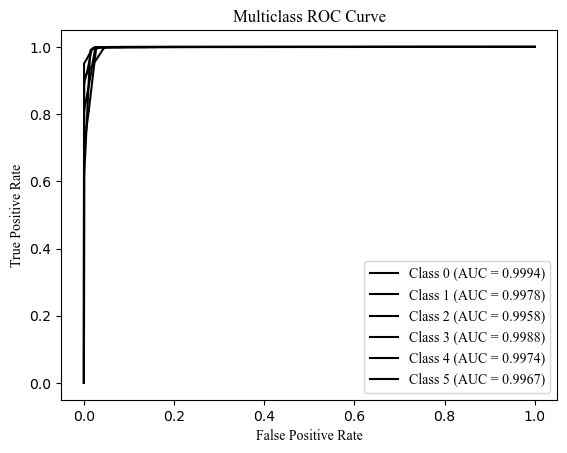

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = len(data["label"].unique())
y_test_bin = label_binarize(y_test, classes=range(n_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], linestyle='-', label=f'Class {i} (AUC = {roc_auc[i]:.4f})', color='black')

plt.title('Multiclass ROC Curve', fontname='Times New Roman')
plt.xlabel('False Positive Rate', fontname='Times New Roman')
plt.ylabel('True Positive Rate', fontname='Times New Roman')
plt.legend(prop={'family': 'Times New Roman'})
plt.show()